# Lab 3 - Backwards Propagation - Neural Network from Scratch

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lab1_4.fetch_and_preprocess import fetch_heart_data, preprocess_heart_data

In [2]:
# fetch dataset 
df = fetch_heart_data()

#preprocess
X_processed, y = preprocess_heart_data(df)

# Create a binary target

In [3]:
# 0 - no heart disease, 1 - heart disease (no matter which type)
y_binary = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Data splitting

In [4]:
# Generated by GPT-5

# --- stratified 60/20/20 split ---
test_size = 0.20
val_size = 0.20  # final fraction for validation

# 1) hold out test first
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_processed, y_binary, test_size=test_size, stratify=y_binary, random_state=42
)

# 2) split train into train/val (adjust val size relative to remaining)
val_size_adj = val_size / (1.0 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_adj, stratify=y_trainval, random_state=42
)

# --- ensure correct NumPy shapes for the network ---
X_train_np = np.asarray(X_train, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

X_val_np = np.asarray(X_val, dtype=np.float32)
y_val_np = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

X_test_np = np.asarray(X_test, dtype=np.float32)
y_test_np = np.asarray(y_test, dtype=np.float32)  # flat for accuracy


# Neural Network Implementation

In [5]:
class Layer:
    """
    Base class for layers in the neural network
    """
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward(self, input):
        """
        Forward propagation.
        Input data is passed as an argument by the previous layer
        """
        raise NotImplementedError
    
    def backward(self, output_gradient, learning_rate=0.01):
        """
        Backward propagation.
        Output gradient is passed as an argument by the next layer.
        Returns the input gradient to be passed to the previous layer.
        """
        raise NotImplementedError
    
class Dense(Layer):
    """
    Layer connected with all the previous and next layer neurons.
    """
    
    def __init__(self, n_inputs, n_outputs, weight_std=0.01, bias_init=0.0, seed=None):
        
        super().__init__()
    
        rng = np.random.default_rng(seed)
        self.W = rng.normal(0.0, weight_std, size=(n_inputs, n_outputs))
        self.b =  np.full((1, n_outputs), bias_init)
        
    def forward(self, input_data):
        """
        Forward propagation.
        input: X, stored in self.input for backward pass
        output: X @ W + b
        """
        self.input = input_data
        self.output = input_data @ self.W + self.b 
        return self.output
    
    def backward(self, output_gradient, learning_rate=0.01):
        """
        Backward propagation.
        input: output gradient from the next layer
        output: calculated input gradient to pass to the previous layer
        result: update weights and biases
        """
        X = self.input
        dW = X.T @ output_gradient  # dL/dW
        db = output_gradient.sum(axis=0, keepdims=True)  # dL/db
        dX = output_gradient @ self.W.T  # dL/dX
        
        #SGD update
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        
        return dX
    
class Activation(Layer):
    """
    Activation layer (e.g., ReLU, Sigmoid)
    """
    
    def __init__(self, activation_function, activation_derivative):
        super().__init__()
        self.activation = activation_function
        self.activation_derivative = activation_derivative
        
    
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(input_data)
        return self.output
    
    def backward(self, output_gradient, learning_rate=0.01):
        """
        calculate dL/d_parameters to update weights and biases
        calculate dL/d_input to pass to the previous layer 
        """
        local = self.activation_derivative(self.output)
        return output_gradient * local
    
class NeuralNetwork: 
    """ 
    Neural Network class to manage layers and training 
    """ 
    def __init__(self, loss, loss_derivative, learning_rate=0.01):
        self.layers = []
        self.loss = loss
        self.loss_derivative = loss_derivative
        self.learning_rate = learning_rate
        
        
    def add(self, layer):
        """ 
        Add layer to the neural network 
        """ 
        self.layers.append(layer) 
        
    def predict(self, X): 
        """ 
        Forward propagation through all layers 
        """ 
        result = X 
        for layer in self.layers: 
            result = layer.forward(result)
        return result 
    
    def backward(self, y_true, y_pred):
        """ 
        Backward propagation through all layers 
        """ 
        gradient = self.loss_derivative(y_true, y_pred)
        
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate=self.learning_rate)
        return 0 
        
    def fit(self, X_train, y_train, epochs, batch_size=32, shuffle=True, verbose=False, X_val=None,y_val=None):
        
        n = X_train.shape[0]
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": []
        }
    
        for epoch in range(epochs):
            if shuffle:
                order = np.random.permutation(n)
                X_train = X_train[order]
                y_train = y_train[order]
    
            # mini-batch loop
            for i in range(0, n, batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                y_pred = self.predict(xb)
                self.backward(yb, y_pred)
    
            # end-of-epoch train metrics
            train_pred = self.predict(X_train)
            train_loss = self.loss(y_train, train_pred)
            train_labels = (train_pred > 0.5).astype(int).ravel()
            train_acc = float(np.mean(train_labels == y_train.ravel()))
            history["train_loss"].append(float(train_loss))
            history["train_acc"].append(train_acc)
    
            # validation metrics
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_loss = self.loss(y_val, val_pred)
                val_labels = (val_pred > 0.5).astype(int).ravel()
                val_acc = float(np.mean(val_labels == y_val.ravel()))
            else:
                val_loss, val_acc = None, None
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            
            if verbose:
                msg = (
                    f"Epoch {epoch+1}/{epochs} "
                    f"train_loss={train_loss:.4f} train_acc={train_acc:.3f}"
                )
                if val_loss is not None:
                    msg += f" val_loss={val_loss:.4f} val_acc={val_acc:.3f}"
                print(msg)
    
        return history
    
    def reinitialize(self, weight_std=0.01, bias_init=0.0, seed=None):
        """
        Reinitialize weights and biases of all Dense layers
        """
        rng = np.random.default_rng(seed)
        for layer in self.layers:
            if isinstance(layer, Dense):
                n_inputs, n_outputs = layer.W.shape
                layer.W = rng.normal(0.0, weight_std, size=(n_inputs, n_outputs))
                layer.b = np.full((1, n_outputs), bias_init)
    

## Activation and loss functions

In [6]:
def sigmoid(x):
    x = np.asarray(x) 
    out = np.empty_like(x, dtype=np.result_type(x, np.float32))
    positive = x >= 0 # for numerical stability, 1+exp(-x) is safe when x >= 0
    out[positive] = 1 / (1 + np.exp(-x[positive])) 
    exp_x = np.exp(x[~positive]) 
    out[~positive] = exp_x / (1.0 + exp_x) 
    return out 
    
def sigmoid_derivative(sig_out): 
    return sig_out * (1 - sig_out) 
    
def relu(x): return np.maximum(0, x) 
def relu_derivative(relu_out): 
    return (relu_out > 0).astype(relu_out.dtype) 
    
def binary_crossentropy(y_true, y_pred, eps=1e-7):
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    y_true = np.asarray(y_true).reshape(y_pred.shape)
    loss = - (y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))
    return np.mean(loss)
    
def binary_crossentropy_derivative(y_true, y_pred, eps=1e-7):
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    y_true = np.asarray(y_true).reshape(y_pred.shape)
    N = y_true.shape[0]
    return (y_pred - y_true) / (y_pred * (1.0 - y_pred)) / N

In [7]:
def build_model(input_dim, hidden_size, learning_rate, weight_std=0.01, bias_init=0.0, seed=None, loss_function=binary_crossentropy, loss_derivative=binary_crossentropy_derivative):
    """
    :param input_dim: feature dimension of the input data
    :param hidden_size: list of hidden layer sizes, e.g., [16, 32] means two hidden layers with 16 and 32 neurons
    :param learning_rate: learning rate for SGD
    :param weight_std: standard deviation for weight initialization
    :param bias_init: initial value for biases
    :param seed: seed for random number generator
    :param loss_function: loss function
    :param loss_derivative: derivative of the loss function 
    :return: model: an instance of NeuralNetwork
    """

    model = NeuralNetwork(loss=loss_function, loss_derivative=loss_derivative, learning_rate=learning_rate)
    
    rng = np.random.default_rng(seed)
    
    in_dim = input_dim
    for i,h in enumerate(hidden_size):
        layer = Dense(n_inputs=in_dim, n_outputs=h, weight_std=weight_std, bias_init=bias_init, seed=rng.integers(1e6))
        model.add(layer)
        model.add(Activation(relu, relu_derivative))
        in_dim = h
        
    model.add(Dense(n_inputs=in_dim, n_outputs=1, weight_std=weight_std, bias_init=bias_init, seed=rng.integers(1e6)))
    model.add(Activation(sigmoid, sigmoid_derivative))
    return model

## Plotting function

In [8]:
def plot_history(histories, title="Training history"):
    if isinstance(histories, dict):
        items = histories.items()
    else:
        items = [("run", histories)]
    plt.figure(figsize=(12,5))
    # Loss
    plt.subplot(1,2,1)
    for label, h in items:
        plt.plot(h['train_loss'], label=f"{label} train")
        if any(v is not None for v in h['val_loss']):
            plt.plot(h['val_loss'], label=f"{label} val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} - Loss"); plt.legend()
    # Accuracy
    plt.subplot(1,2,2)
    for label, h in items:
        plt.plot(h['train_acc'], label=f"{label} train")
        if any(v is not None for v in h['val_acc']):
            plt.plot(h['val_acc'], label=f"{label} val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} - Accuracy"); plt.legend()
    plt.show()

## Width sweep

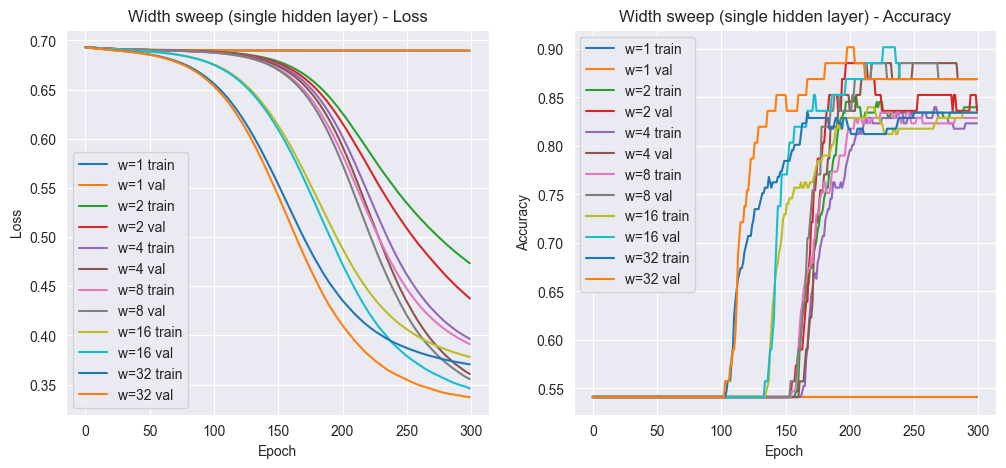

   width  learning_rate  weight_std  train_loss  train_acc  val_loss  \
0      1           0.01        0.01    0.689711   0.541436  0.689784   
1      2           0.01        0.01    0.473333   0.839779  0.437545   
2      4           0.01        0.01    0.396448   0.823204  0.360735   
3      8           0.01        0.01    0.391164   0.828729  0.355509   
4     16           0.01        0.01    0.378123   0.834254  0.346102   
5     32           0.01        0.01    0.370535   0.834254  0.337113   

    val_acc  test_loss  test_acc  
0  0.540984   0.689784  0.540984  
1  0.836066   0.424321  0.868852  
2  0.868852   0.318303  0.901639  
3  0.868852   0.315433  0.901639  
4  0.868852   0.299846  0.901639  
5  0.868852   0.296713  0.901639  


In [9]:
def run_width_sweep(widths, learning_rate=0.01, weight_std=0.01, bias_init=0.0, seed=42, epochs=300, batch_size=32):
    histories = {}
    rows = []
    for w in widths:
        model = build_model(
            input_dim=X_train_np.shape[1],
            hidden_size=[w],
            learning_rate=learning_rate,
            weight_std=weight_std,
            bias_init=bias_init,
            seed=seed
        )
        hist = model.fit(
            X_train_np,
            y_train_np,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            X_val=X_val_np,
            y_val=y_val_np
        )
        histories[f"w={w}"] = hist

        # final metrics
        val_loss = hist["val_loss"][-1]
        val_acc = hist["val_acc"][-1]
        train_loss = hist["train_loss"][-1]
        train_acc = hist["train_acc"][-1]

        test_pred = model.predict(X_test_np)
        test_loss = binary_crossentropy(y_test_np.reshape(-1,1), test_pred)

        # test accuracy fix - generated by GPT-5        
        test_labels = (test_pred > 0.5).astype(int).ravel()
        test_acc = float((test_labels == y_test_np.ravel()).mean())

        rows.append({
            "width": w,
            "learning_rate": learning_rate,
            "weight_std": weight_std,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })

    df = pd.DataFrame(rows).sort_values("width", ascending=True).reset_index(drop=True)
    plot_history(histories, title="Width sweep (single hidden layer)")
    return histories, df

# widths to test
widths = [1, 2, 4, 8, 16, 32]

# run sweep
histories, results_df = run_width_sweep(widths, learning_rate=0.01, weight_std=0.01, epochs=300, batch_size=32)
print(results_df)

### Key observations
- Capacity threshold: width 1 - fails (accuracy stuck at ~54%), width 2 - learns, but underperforms, width 4+ - good performance
- Accuracy gains between widths 4, 8, 16, 32 are marginal, widths 16 and 32 performing with the same accuracy
- The more complex the model (wider), the faster the convergence (fewer epochs to reach high accuracy)



## Learning rate sweep

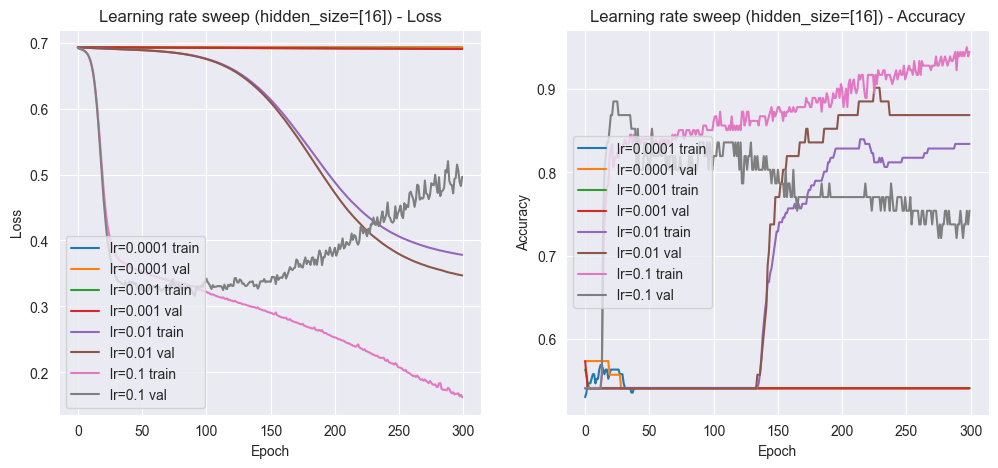

   learning_rate hidden_size  weight_std  train_loss  train_acc  val_loss  \
0         0.0001        [16]        0.01    0.692738   0.541436  0.692707   
1         0.0010        [16]        0.01    0.690404   0.541436  0.690396   
2         0.0100        [16]        0.01    0.378205   0.834254  0.347070   
3         0.1000        [16]        0.01    0.162307   0.944751  0.496665   

    val_acc  test_loss  test_acc  
0  0.540984   0.692735  0.540984  
1  0.540984   0.690319  0.540984  
2  0.868852   0.300606  0.901639  
3  0.754098   0.451474  0.836066  


In [10]:
def run_lr_sweep(
    learning_rates,
    hidden_size=[16],
    weight_std=0.01,
    bias_init=0.0,
    seed=42,
    epochs=300,
    batch_size=32
):
    histories = {}
    rows = []
    for lr in learning_rates:
        model = build_model(
            input_dim=X_train_np.shape[1],
            hidden_size=hidden_size,
            learning_rate=lr,
            weight_std=weight_std,
            bias_init=bias_init,
            seed=seed
        )
        hist = model.fit(
            X_train_np,
            y_train_np,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            X_val=X_val_np,
            y_val=y_val_np
        )
        label = f"lr={lr}"
        histories[label] = hist

        train_loss = hist["train_loss"][-1]
        train_acc = hist["train_acc"][-1]
        val_loss = hist["val_loss"][-1]
        val_acc = hist["val_acc"][-1]

        test_pred = model.predict(X_test_np)
        test_loss = binary_crossentropy(y_test_np.reshape(-1, 1), test_pred)
        test_labels = (test_pred > 0.5).astype(int).ravel()
        test_acc = float((test_labels == y_test_np.ravel()).mean())

        rows.append({
            "learning_rate": lr,
            "hidden_size": hidden_size,
            "weight_std": weight_std,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })

    df = pd.DataFrame(rows).sort_values("learning_rate", ascending=True).reset_index(drop=True)
    plot_history(histories, title=f"Learning rate sweep (hidden_size={hidden_size})")
    return histories, df

# example rates to test
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

histories_lr, results_lr_df = run_lr_sweep(
    learning_rates,
    hidden_size=[16],
    weight_std=0.01,
    epochs=300,
    batch_size=32
)

print(results_lr_df)

### Key observations
- Very low learning rates (1e-4, 1e-3) lead to slow convergence, not reaching high accuracy within 300 epochs
- Moderate learning rate (1e-2) achieves good accuracy (~85%) with steady convergence
- High learning rate (1e-1) causes overfitting, performing well on training but poorly on validation and test sets

## Weight initialization sweep

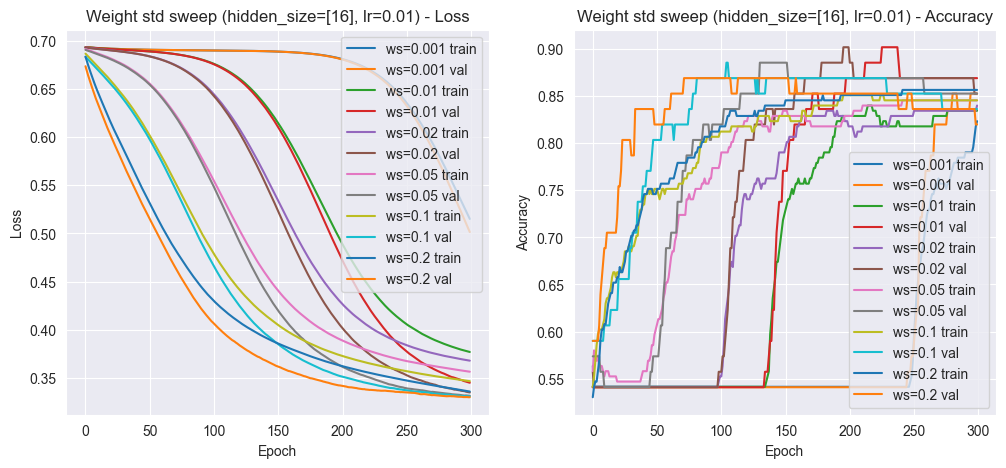

   weight_std hidden_size  learning_rate  train_loss  train_acc  val_loss  \
0       0.001        [16]           0.01    0.515108   0.823204  0.501481   
1       0.010        [16]           0.01    0.377209   0.834254  0.345319   
2       0.020        [16]           0.01    0.368207   0.839779  0.335248   
3       0.050        [16]           0.01    0.356750   0.845304  0.331792   
4       0.100        [16]           0.01    0.346945   0.845304  0.331167   
5       0.200        [16]           0.01    0.336215   0.856354  0.330347   

    val_acc  test_loss  test_acc  
0  0.852459   0.469132  0.885246  
1  0.868852   0.301843  0.901639  
2  0.852459   0.295543  0.901639  
3  0.852459   0.290215  0.885246  
4  0.836066   0.289190  0.885246  
5  0.819672   0.288166  0.868852  


In [11]:
def run_weight_std_sweep(
    weight_stds,
    hidden_size=[16],
    learning_rate=0.01,
    bias_init=0.0,
    seed=42,
    epochs=300,
    batch_size=32
):
    histories = {}
    rows = []
    for ws in weight_stds:
        model = build_model(
            input_dim=X_train_np.shape[1],
            hidden_size=hidden_size,
            learning_rate=learning_rate,
            weight_std=ws,
            bias_init=bias_init,
            seed=seed
        )
        hist = model.fit(
            X_train_np,
            y_train_np,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            X_val=X_val_np,
            y_val=y_val_np
        )
        label = f"ws={ws}"
        histories[label] = hist

        train_loss = hist["train_loss"][-1]
        train_acc = hist["train_acc"][-1]
        val_loss = hist["val_loss"][-1]
        val_acc = hist["val_acc"][-1]

        test_pred = model.predict(X_test_np)
        test_loss = binary_crossentropy(y_test_np.reshape(-1, 1), test_pred)
        test_labels = (test_pred > 0.5).astype(int).ravel()
        test_acc = float((test_labels == y_test_np.ravel()).mean())

        rows.append({
            "weight_std": ws,
            "hidden_size": hidden_size,
            "learning_rate": learning_rate,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })

    df = pd.DataFrame(rows).sort_values("weight_std", ascending=True).reset_index(drop=True)
    plot_history(histories, title=f"Weight std sweep (hidden_size={hidden_size}, lr={learning_rate})")
    return histories, df

# example stds to test
weight_stds = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]

histories_ws, results_ws_df = run_weight_std_sweep(
    weight_stds,
    hidden_size=[16],
    learning_rate=0.01,
    epochs=300,
    batch_size=32
)

print(results_ws_df)


### Key observations
- Very small weight std (0.001) leads to slow learning, not reaching high accuracy within 300 epochs
- Moderate weight stds (0.005, 0.02) achieve best accuracy (85%+ for validation set and 90% for test set) with the given learning rate = 0.01
- Convergence speed improves with weight_std, however too high values (0.1, 0.2) lead to lower final accuracy, likely due to getting stuck in poor local minima

## Depth sweep


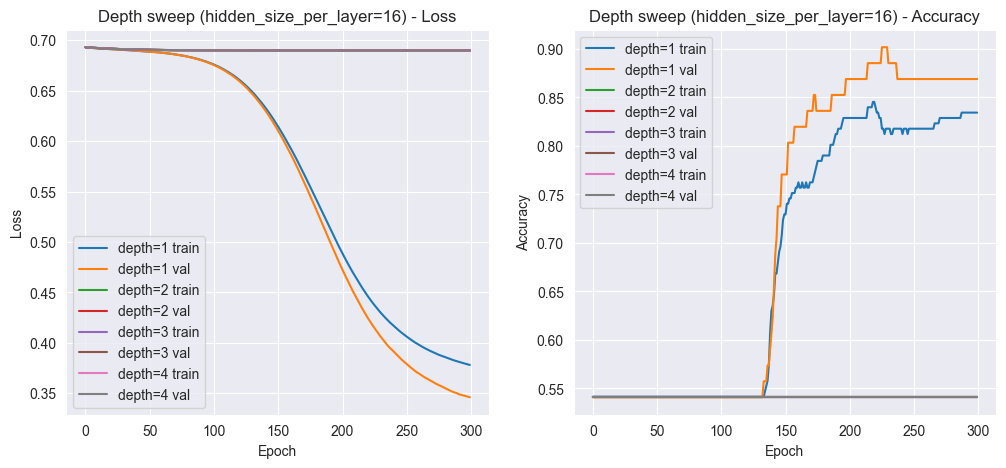

   depth  hidden_size_per_layer  learning_rate  train_loss  train_acc  \
0      1                     16           0.01    0.378106   0.834254   
1      2                     16           0.01    0.689703   0.541436   
2      3                     16           0.01    0.689710   0.541436   
3      4                     16           0.01    0.689709   0.541436   

   val_loss   val_acc  test_loss  test_acc  
0  0.346085  0.868852   0.300481  0.901639  
1  0.689781  0.540984   0.689776  0.540984  
2  0.689784  0.540984   0.689784  0.540984  
3  0.689784  0.540984   0.689784  0.540984  


In [12]:
def run_depth_sweep(
    depths,
    hidden_size_per_layer=16,
    learning_rate=0.01,
    weight_std=0.01,
    bias_init=0.0,
    seed=42,
    epochs=300,
    batch_size=32
):
    histories = {}
    rows = []
    for d in depths:
        hidden_sizes = [hidden_size_per_layer] * d
        model = build_model(
            input_dim=X_train_np.shape[1],
            hidden_size=hidden_sizes,
            learning_rate=learning_rate,
            weight_std=weight_std,
            bias_init=bias_init,
            seed=seed
        )
        hist = model.fit(
            X_train_np,
            y_train_np,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            X_val=X_val_np,
            y_val=y_val_np
        )
        label = f"depth={d}"
        histories[label] = hist

        train_loss = hist["train_loss"][-1]
        train_acc = hist["train_acc"][-1]
        val_loss = hist["val_loss"][-1]
        val_acc = hist["val_acc"][-1]

        test_pred = model.predict(X_test_np)
        test_loss = binary_crossentropy(y_test_np.reshape(-1, 1), test_pred)
        test_labels = (test_pred > 0.5).astype(int).ravel()
        test_acc = float((test_labels == y_test_np.ravel()).mean())

        rows.append({
            "depth": d,
            "hidden_size_per_layer": hidden_size_per_layer,
            "learning_rate": learning_rate,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })

    df = pd.DataFrame(rows).sort_values("depth", ascending=True).reset_index(drop=True)
    plot_history(histories, title=f"Depth sweep (hidden_size_per_layer={hidden_size_per_layer})")
    return histories, df

# example depths to test
depths = [1, 2, 3, 4]
histories_depth, results_depth_df = run_depth_sweep(
    depths,
    hidden_size_per_layer=16,
    learning_rate=0.01,
    weight_std=0.01,
    epochs=300,
    batch_size=32
)
print(results_depth_df)


### Key observations
- Only depth=1 trains successfully, reaching ~85% validation accuracy
- Depths 2, 3, 4 fail to learn, stuck at ~50
- Increasing depth did not cause overfitting, it prevented learning entirely.
- Possible reasons: insufficient model capacity, or inappropriate hyperparameters for deeper networks

## Normal vs. Standardized Data

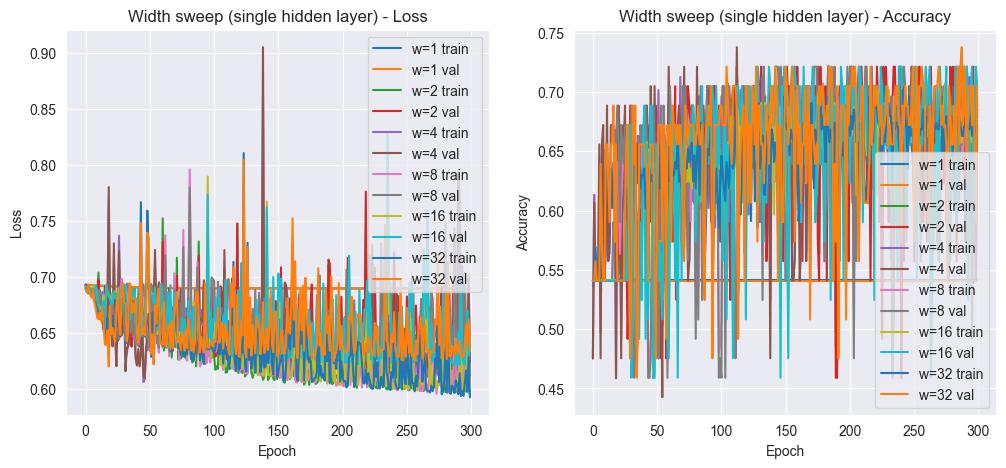

Width sweep (unstandardized):
   width  learning_rate  weight_std  train_loss  train_acc  val_loss  \
0      1           0.01        0.01    0.689709   0.541436  0.689785   
1      2           0.01        0.01    0.598106   0.679558  0.629506   
2      4           0.01        0.01    0.610359   0.696133  0.623376   
3      8           0.01        0.01    0.595482   0.685083  0.629517   
4     16           0.01        0.01    0.610822   0.668508  0.644952   
5     32           0.01        0.01    0.592583   0.685083  0.634336   

    val_acc  test_loss  test_acc  
0  0.540984   0.689785  0.540984  
1  0.688525   0.548658  0.754098  
2  0.672131   0.595213  0.721311  
3  0.704918   0.564714  0.770492  
4  0.704918   0.549062  0.721311  
5  0.704918   0.559646  0.754098  


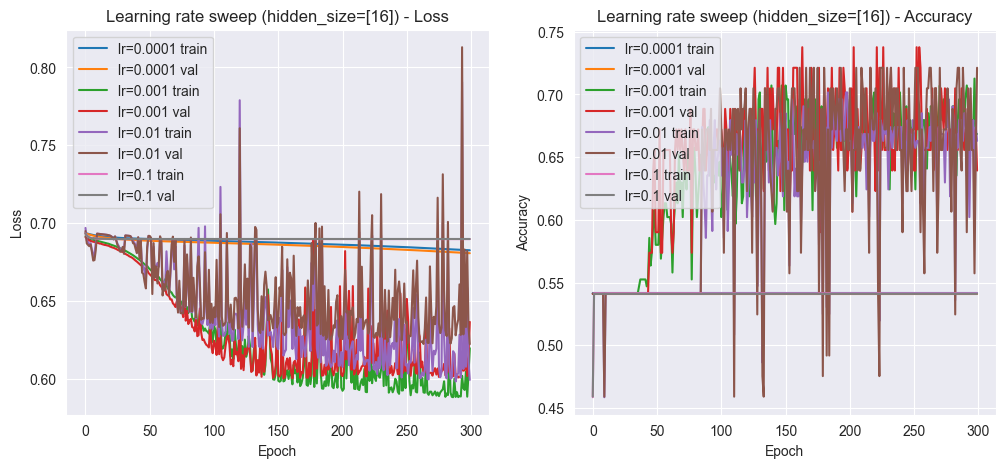


Learning-rate sweep (unstandardized):
   learning_rate hidden_size  weight_std  train_loss  train_acc  val_loss  \
0         0.0001        [16]        0.01    0.682538   0.541436  0.680655   
1         0.0010        [16]        0.01    0.619641   0.668508  0.636521   
2         0.0100        [16]        0.01    0.599273   0.662983  0.622253   
3         0.1000        [16]        0.01    0.689709   0.541436  0.689785   

    val_acc  test_loss  test_acc  
0  0.540984   0.680825  0.540984  
1  0.639344   0.591957  0.672131  
2  0.721311   0.558782  0.754098  
3  0.540984   0.689785  0.540984  


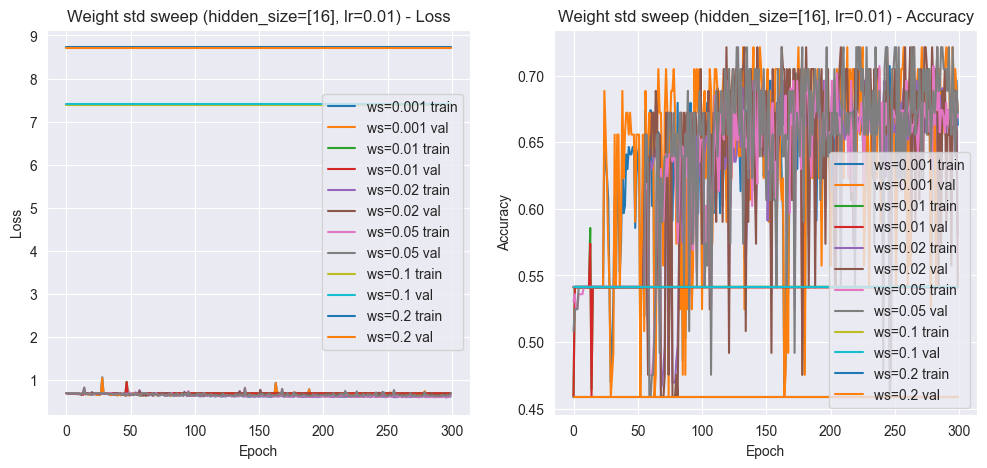


Weight std sweep (unstandardized):
   weight_std hidden_size  learning_rate  train_loss  train_acc  val_loss  \
0       0.001        [16]           0.01    0.616724   0.662983  0.647644   
1       0.010        [16]           0.01    0.689710   0.541436  0.689784   
2       0.020        [16]           0.01    0.674223   0.580110  0.693165   
3       0.050        [16]           0.01    0.645909   0.668508  0.684676   
4       0.100        [16]           0.01    7.391171   0.541436  7.398470   
5       0.200        [16]           0.01    8.726925   0.458564  8.719626   

    val_acc  test_loss  test_acc  
0  0.672131   0.556762  0.704918  
1  0.540984   0.689784  0.540984  
2  0.540984   0.663003  0.622951  
3  0.672131   0.570636  0.704918  
4  0.540984   7.398470  0.540984  
5  0.459016   8.719626  0.459016  


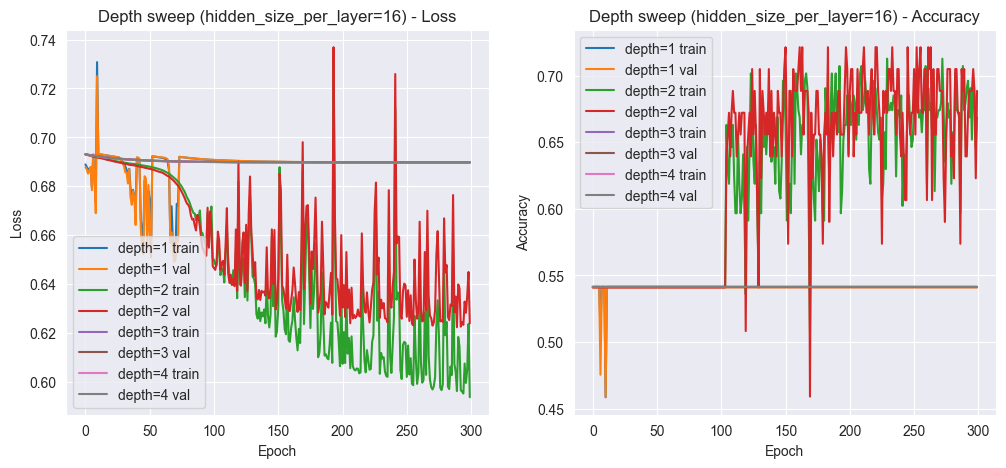


Depth sweep (unstandardized):
   depth  hidden_size_per_layer  learning_rate  train_loss  train_acc  \
0      1                     16           0.01    0.689715   0.541436   
1      2                     16           0.01    0.593655   0.668508   
2      3                     16           0.01    0.689709   0.541436   
3      4                     16           0.01    0.689711   0.541436   

   val_loss   val_acc  test_loss  test_acc  
0  0.689787  0.540984   0.689787  0.540984  
1  0.623889  0.688525   0.558156  0.737705  
2  0.689782  0.540984   0.689782  0.540984  
3  0.689785  0.540984   0.689785  0.540984  


In [13]:
#Generated by GPT-5


# Unstandardized data split (60/20/20) and reuse of existing sweep functions

# 1) get unstandardized features
df = fetch_heart_data()
X_ns, _ = preprocess_heart_data(df, scale=False)
y_binary = df['num'].apply(lambda x: 1 if x > 0 else 0)

# 2) stratified 60/20/20 split on X_ns
from sklearn.model_selection import train_test_split

test_size = 0.20
val_size = 0.20  # final fraction for validation

X_trainval_ns, X_test_ns, y_trainval_ns, y_test_ns = train_test_split(
    X_ns, y_binary, test_size=test_size, stratify=y_binary, random_state=42
)

val_size_adj = val_size / (1.0 - test_size)
X_train_ns, X_val_ns, y_train_ns, y_val_ns = train_test_split(
    X_trainval_ns, y_trainval_ns, test_size=val_size_adj, stratify=y_trainval_ns, random_state=42
)

# 3) to NumPy (match shapes expected by the network)
import numpy as np

X_train_np = np.asarray(X_train_ns, dtype=np.float32)
y_train_np = np.asarray(y_train_ns, dtype=np.float32).reshape(-1, 1)

X_val_np = np.asarray(X_val_ns, dtype=np.float32)
y_val_np = np.asarray(y_val_ns, dtype=np.float32).reshape(-1, 1)

X_test_np = np.asarray(X_test_ns, dtype=np.float32)
y_test_np = np.asarray(y_test_ns, dtype=np.float32)  # flat for accuracy

# 4) run the SAME sweeps using the existing helpers

# Width sweep
widths = [1, 2, 4, 8, 16, 32]
hist_w_ns, res_w_ns = run_width_sweep(
    widths, learning_rate=0.01, weight_std=0.01, epochs=300, batch_size=32
)
print("Width sweep (unstandardized):")
print(res_w_ns)

# Learning-rate sweep
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
hist_lr_ns, res_lr_ns = run_lr_sweep(
    learning_rates, hidden_size=[16], weight_std=0.01, epochs=300, batch_size=32
)
print("\nLearning-rate sweep (unstandardized):")
print(res_lr_ns)

# Weight std sweep
weight_stds = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
hist_ws_ns, res_ws_ns = run_weight_std_sweep(
    weight_stds, hidden_size=[16], learning_rate=0.01, epochs=300, batch_size=32
)
print("\nWeight std sweep (unstandardized):")
print(res_ws_ns)

# Depth sweep
depths = [1, 2, 3, 4]
hist_d_ns, res_d_ns = run_depth_sweep(
    depths, hidden_size_per_layer=16, learning_rate=0.01, weight_std=0.01, epochs=300, batch_size=32
)
print("\nDepth sweep (unstandardized):")
print(res_d_ns)


### Key observations
- Overall, unstandardized data leads to chaotic, unstable training across all sweeps
- Width sweep: no clear trend, accuracies vary widely without improvement with width
- Learning rate sweep: no consistent pattern, high learning rates cause divergence
- Weight std sweep: no clear optimal value, training is erratic
- Depth sweep: all depths fail to learn, stuck at ~50% accuracy, depth=2 finding a lucky local minimum in the last steps
- Conclusion: Standardization is crucial for stable and effective training of neural networks

# Final Hyperparameter Tuning

In [14]:
# Generated by GPT-5
# fetch dataset 
df = fetch_heart_data()

#preprocess
X_processed, y = preprocess_heart_data(df)

# Create a binary target
y_binary = df['num'].apply(lambda x: 1 if x > 0 else 0)


# --- stratified 60/20/20 split ---
test_size = 0.20
val_size = 0.20  # final fraction for validation

# 1) hold out test first
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_processed, y_binary, test_size=test_size, stratify=y_binary, random_state=42
)

# 2) split train into train/val (adjust val size relative to remaining)
val_size_adj = val_size / (1.0 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_adj, stratify=y_trainval, random_state=42
)

# --- ensure correct NumPy shapes for the network ---
X_train_np = np.asarray(X_train, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

X_val_np = np.asarray(X_val, dtype=np.float32)
y_val_np = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

X_test_np = np.asarray(X_test, dtype=np.float32)
y_test_np = np.asarray(y_test, dtype=np.float32)  # flat for accuracy


In [15]:
import itertools
import numpy as np
import pandas as pd

# Grid
depths = [1, 2]
widths = [4, 8, 16, 32]
learning_rates = [0.005, 0.01, 0.02]
weight_stds = [0.005, 0.01, 0.02]
bias_inits = [0.0]
batch_sizes = [32]
epochs = 300
seeds = [42, 123]

def build_hidden_sizes(depth, width):
    return [width] * depth

def evaluate_config(hidden_sizes, lr, wstd, binit, batch_size, epochs, seed):
    model = build_model(
        input_dim=X_train_np.shape[1],
        hidden_size=hidden_sizes,
        learning_rate=lr,
        weight_std=wstd,
        bias_init=binit,
        seed=seed
    )
    hist = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        X_val=X_val_np,
        y_val=y_val_np
    )
    train_loss = hist["train_loss"][-1]; train_acc = hist["train_acc"][-1]
    val_loss = hist["val_loss"][-1];     val_acc  = hist["val_acc"][-1]
    test_pred = model.predict(X_test_np)
    test_loss = binary_crossentropy(y_test_np.reshape(-1,1), test_pred)
    test_labels = (test_pred > 0.5).astype(int).ravel()
    test_acc = float(np.mean(test_labels == y_test_np.ravel()))
    return {
        "hidden_sizes": hidden_sizes,
        "learning_rate": lr,
        "weight_std": wstd,
        "bias_init": binit,
        "batch_size": batch_size,
        "seed": seed,
        "train_loss": float(train_loss),
        "train_acc": float(train_acc),
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc)
    }

def is_finite_metrics(d):
    vals = [d[k] for k in ["train_loss","train_acc","val_loss","val_acc","test_loss","test_acc"]]
    return np.all(np.isfinite(vals))

results = []
failures = []

expected_total = (len(depths)*len(widths)*len(learning_rates)*
                  len(weight_stds)*len(bias_inits)*len(batch_sizes))

for depth, width, lr, wstd, binit, bsz in itertools.product(
    depths, widths, learning_rates, weight_stds, bias_inits, batch_sizes
):
    hidden_sizes = build_hidden_sizes(depth, width)
    seed_runs = []
    for sd in seeds:
        try:
            r = evaluate_config(hidden_sizes, lr, wstd, binit, bsz, epochs, sd)
            if not is_finite_metrics(r):
                raise ValueError("Non-finite metric encountered.")
            seed_runs.append(r)
        except Exception as e:
            failures.append({
                "hidden_sizes": hidden_sizes, "lr": lr, "wstd": wstd,
                "binit": binit, "bsz": bsz, "seed": sd, "error": repr(e)
            })
            # skip this config entirely if any seed fails
            seed_runs = []
            break
    if not seed_runs:
        continue
    agg = {
        "hidden_sizes": hidden_sizes,
        "learning_rate": lr,
        "weight_std": wstd,
        "bias_init": binit,
        "batch_size": bsz
    }
    for metric in ["train_loss","train_acc","val_loss","val_acc","test_loss","test_acc"]:
        vals = [r[metric] for r in seed_runs]
        agg[metric] = float(np.mean(vals))
        agg[metric + "_std"] = float(np.std(vals))
    results.append(agg)

print(f"Completed {len(results)} of {expected_total} configurations. Skipped {len(failures)}.")
if failures:
    print("First few failures (showing up to 5):")
    for f in failures[:5]:
        print(f)

if not results:
    raise RuntimeError("No successful configurations. Consider standardizing features (scale=True).")

df = pd.DataFrame(results).sort_values(["val_acc","val_loss"], ascending=[False, True]).reset_index(drop=True)
print("Top configurations:")
print(df.head(10))

best = df.iloc[0]
print("\nBest hyperparameters:")
print({
    "hidden_sizes": best.hidden_sizes,
    "learning_rate": best.learning_rate,
    "weight_std": best.weight_std,
    "bias_init": best.bias_init,
    "batch_size": best.batch_size,
    "val_acc": best.val_acc,
    "val_loss": best.val_loss,
    "test_acc": best.test_acc,
    "test_loss": best.test_loss
})

def retrain_on_full_train(best_cfg, epochs=epochs):
    X_full = np.vstack([X_train_np, X_val_np])
    y_full = np.vstack([y_train_np, y_val_np])
    model = build_model(
        input_dim=X_full.shape[1],
        hidden_size=best_cfg["hidden_sizes"],
        learning_rate=best_cfg["learning_rate"],
        weight_std=best_cfg["weight_std"],
        bias_init=best_cfg["bias_init"],
        seed=999
    )
    model.fit(X_full, y_full, epochs=epochs, batch_size=best_cfg["batch_size"], shuffle=True, X_val=None, y_val=None)
    test_pred = model.predict(X_test_np)
    final_test_loss = binary_crossentropy(y_test_np.reshape(-1,1), test_pred)
    final_test_acc = float(np.mean((test_pred > 0.5).astype(int).ravel() == y_test_np.ravel()))
    print("\nFinal re-trained test metrics:", {"test_loss": final_test_loss, "test_acc": final_test_acc})


Completed 72 of 72 configurations. Skipped 0.
Top configurations:
  hidden_sizes  learning_rate  weight_std  bias_init  batch_size  train_loss  \
0          [4]          0.010       0.005        0.0          32    0.434804   
1         [32]          0.005       0.020        0.0          32    0.459666   
2          [8]          0.010       0.005        0.0          32    0.407524   
3         [32]          0.010       0.010        0.0          32    0.369513   
4          [8]          0.010       0.020        0.0          32    0.373072   
5         [32]          0.010       0.005        0.0          32    0.378188   
6         [16]          0.010       0.010        0.0          32    0.377478   
7          [8]          0.010       0.010        0.0          32    0.384595   
8          [4]          0.010       0.020        0.0          32    0.380087   
9         [16]          0.010       0.005        0.0          32    0.391818   

   train_loss_std  train_acc  train_acc_std  val_loss

In [16]:
retrain_on_full_train({
    "hidden_sizes": best.hidden_sizes,
    "learning_rate": best.learning_rate,
    "weight_std": best.weight_std,
    "bias_init": best.bias_init,
    "batch_size": best.batch_size
})



Final re-trained test metrics: {'test_loss': np.float64(0.3574986591130191), 'test_acc': 0.8688524590163934}
